In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines.utils import k_fold_cross_validation
from sklearn.model_selection import train_test_split

In [2]:
# Obtener la ruta absoluta del directorio actual (donde está el script o notebook)
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subimos un nivel

# Construir la ruta relativa a la carpeta "Datos"
ruta_bdd = os.path.join(base_dir, "Datos", "database.xlsx")

# Leer el archivo de datos
data = pd.read_excel(ruta_bdd, sheet_name=None)


In [3]:
# Concatenamos los dataframes de cada key:
data = pd.concat(data.values(), ignore_index=True)
print(data.shape)
data.head()

(50, 20)


,FECHA,Caudal,TPH,% Solido,Presion,Bateria,Ciclón,Medicion,horometro,camino_id,uso_230,TPH_acum,dias_230,solido_uso,carga_solidos_efectiva,ratio_tph_caudal,solido_presion,score,score_out,E
0,2019-03-18,3597.082433,4411.410040,70.733724,9.834485,BHC 1011,CyA,240.0,17987.828125,1011 CyA_2018-09-03,7.769185,17645.640160,196,806.616845,3569.200270,1.226386,695.629739,0.032372,0,1
1,2024-08-18,5618.364990,4718.561523,59.569263,10.484711,BHC 1011,CyB,233.5,50149.431641,1011 CyB_2024-07-31,5.004379,9437.123047,18,992.097028,1534.345463,0.839846,624.566522,0.021432,0,0
2,2017-11-07,3670.201487,4837.450935,69.523774,9.905015,BHC 1011,CyF,235.0,13588.043945,1011 CyF_2017-09-12,7.086742,9674.901870,56,859.725387,2035.672278,1.318034,688.634014,0.030156,0,0
3,2020-06-15,3729.695813,4095.470163,69.796485,9.795065,BHC 1011,CyG,240.0,25063.132812,1011 CyG_2019-10-08,8.229440,8190.940325,251,756.237500,1511.840380,1.098071,683.661131,0.034289,0,1
4,2024-09-10,4954.049217,4812.063802,62.948331,7.701962,BHC 1011,CyG,232.5,49058.373047,1011 CyG_2024-07-31,6.147913,14436.191406,41,880.653280,2361.581207,0.971340,484.825678,0.026443,0,0


In [8]:
data.columns

Index(['FECHA', 'Caudal', 'TPH', '% Solido', 'Presion', 'Bateria', 'Ciclón',
       'Medicion', 'horometro', 'camino_id', 'uso_230', 'TPH_acum', 'dias_230',
       'solido_uso', 'carga_solidos_efectiva', 'ratio_tph_caudal',
       'solido_presion', 'score', 'score_out', 'E'],
      dtype='object')

In [18]:
from lifelines import CoxPHFitter

# Seleccionar las columnas relevantes para el modelo
formula_str = "uso_230 + TPH_acum + horometro"

# Ajustar el modelo de riesgos proporcionales de Cox
cph = CoxPHFitter()
cph.fit(data, duration_col="dias_230", event_col="E", formula = formula_str)

# Mostrar el resumen del modelo
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 50 total observations, 26 right-censored observations>
             duration col = 'dias_230'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 50
number of events observed = 24
   partial log-likelihood = -45.82
         time fit was run = 2025-02-19 19:47:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
uso_230   -2.63      0.07      0.58           -3.76           -1.50                0.02                0.22
TPH_acum  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
horometro -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

           cmp to     z      p  -log2(p)
covariate                               
uso_230      0.00 -4.56 <0.005     17.55
TPH_acum     0.00 -2.10   0.04      4.81
horometro    0.00 -2.96 <0.005      8.36
---
Concordance = 0.90
Partial AIC = 97.63
log-likelihood ratio test = 43.10 on 3 df
-log2(p) of ll-ratio test = 28.67

### Evaluación

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from IPython.display import display

# ------------------------------------------------------------
# 1. Dividir datos en entrenamiento y prueba
# ------------------------------------------------------------
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# ------------------------------------------------------------
# 2. Ajustar el modelo de Cox en el set de entrenamiento
# ------------------------------------------------------------
formula_str = "uso_230 + TPH_acum + horometro"  # Ajusta según tus covariables

cph = CoxPHFitter()
cph.fit(train_data, duration_col="dias_230", event_col="E", formula=formula_str)

print("Resumen del modelo Cox (con datos de entrenamiento):")
cph.print_summary()  # Coeficientes, p-valores, etc.

# ------------------------------------------------------------
# 3. Evaluar el desempeño en el set de prueba
# ------------------------------------------------------------
# 3.1. Calcular el riesgo parcial (hazard) para cada individuo en test
pred_risk = cph.predict_partial_hazard(test_data)

# 3.2. Calcular c-index
# Nota: En supervivencia, un riesgo mayor implica tiempo de supervivencia más corto,
# por ello usamos "-pred_risk" para que un valor mayor se asocie a ocurrencia más temprana.
c_index = concordance_index(
    event_times=test_data["dias_230"],
    predicted_scores=-pred_risk,
    event_observed=test_data["E"]
)
print(f"\nC-index en el set de prueba: {c_index:.3f}")

Resumen del modelo Cox (con datos de entrenamiento):


<lifelines.CoxPHFitter: fitted with 40 total observations, 20 right-censored observations>
             duration col = 'dias_230'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 40
number of events observed = 20
   partial log-likelihood = -32.69
         time fit was run = 2025-02-19 19:50:26 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
uso_230   -2.65      0.07      0.66           -3.95           -1.35                0.02                0.26
TPH_acum  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
horometro -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

           cmp to     z      p  -log2(p)
covariate                               
uso_230      0.00 -4.00 <0.005     13.95
TPH_acum     0.00 -2.29   0.02      5.52
horometro    0.00 -3.09 <0.005      8.96
---
Concordance = 0.90
Partial AIC = 71.37
log-likelihood ratio test = 37.64 on 3 df
-log2(p) of ll-ratio test = 24.83


C-index en el set de prueba: 0.923


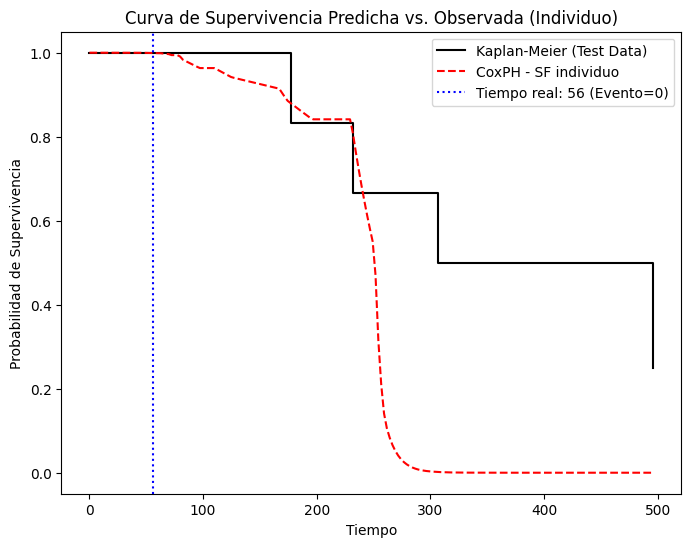


Predicciones (primeras 10 filas) con horizonte = 200 días:


,dias_230,E,uso_230,TPH_acum,horometro,pred_risk,surv_prob_200
13,307,1,8.490988,18159.015625,25425.819946,0.022336,0.984834
39,496,0,8.570493,18587.004993,25412.865234,0.016603,0.988704
30,56,0,6.547343,11973.813721,48206.035156,0.252295,0.841456
45,482,0,8.611232,18970.563907,25504.330078,0.013553,0.990770
17,232,1,8.040083,13471.856445,25641.679688,0.186433,0.880242
48,496,1,8.828850,18705.690860,32302.919922,0.002433,0.998337
26,118,0,7.522314,8700.510730,14855.285156,13.067678,0.000131
25,16,0,5.794629,8757.647949,42210.432617,10.321568,0.000857
32,177,1,7.713571,18044.667926,21926.113281,0.332524,0.796510
19,56,0,6.939576,11973.813721,46996.837891,0.110244,0.927345


In [20]:
# ------------------------------------------------------------
# 4. Presentar predicciones
# ------------------------------------------------------------
# 4.1. Curva de supervivencia predicha para un individuo en test
sample_subject = test_data.sample(1, random_state=0).copy()

# Información real del individuo
actual_time = sample_subject["dias_230"].values[0]
actual_event = sample_subject["E"].values[0]

# Rango de tiempos para graficar la función de supervivencia
tiempos = np.linspace(0, test_data["dias_230"].max(), 200)

# Curva de supervivencia predicha para el individuo
sf_pred = cph.predict_survival_function(sample_subject, times=tiempos)

# Comparación con Kaplan-Meier (en todo el set de prueba)
kmf = KaplanMeierFitter()
kmf.fit(test_data["dias_230"], event_observed=test_data["E"])

plt.figure(figsize=(8,6))
plt.step(kmf.survival_function_.index,
         kmf.survival_function_["KM_estimate"],
         where="post", label="Kaplan-Meier (Test Data)", color="black")
plt.plot(tiempos, sf_pred.iloc[:, 0],
         label="CoxPH - SF individuo", linestyle="--", color="red")

plt.axvline(actual_time, color="blue", linestyle=":",
            label=f"Tiempo real: {actual_time} (Evento={actual_event})")

plt.title("Curva de Supervivencia Predicha vs. Observada (Individuo)")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.legend()
plt.show()

# 4.2. Tabla de predicciones para varios individuos
#    - Riesgo parcial (pred_risk)
#    - Probabilidad de supervivencia a un horizonte de tiempo (ej. t=200 días)
horizonte = 200
test_data = test_data.copy()  # Para evitar SettingWithCopyWarning
test_data["pred_risk"] = pred_risk
# predice la supervivencia a un tiempo fijo para cada individuo
sf_200 = cph.predict_survival_function(test_data, times=[horizonte]).T
test_data[f"surv_prob_{horizonte}"] = sf_200.iloc[:, 0].values

# Mostrar las primeras filas
print(f"\nPredicciones (primeras 10 filas) con horizonte = {horizonte} días:")
display(test_data[[
    "dias_230", "E", "uso_230", "TPH_acum", "horometro", "pred_risk", f"surv_prob_{horizonte}"
]].head(10))


Individuo seleccionado:


,FECHA,Caudal,TPH,% Solido,Presion,Bateria,Ciclón,Medicion,horometro,camino_id,uso_230,TPH_acum,dias_230,solido_uso,carga_solidos_efectiva,ratio_tph_caudal,solido_presion,score,score_out,E
48,2019-03-18,5075.901583,4676.422715,73.100256,9.759706,BHC 1014,CyC,240.0,32302.919922,1014 CyC_2017-11-07,8.82885,18705.69086,496,743.73152,2557.215444,0.921299,713.437025,0.036787,0,1


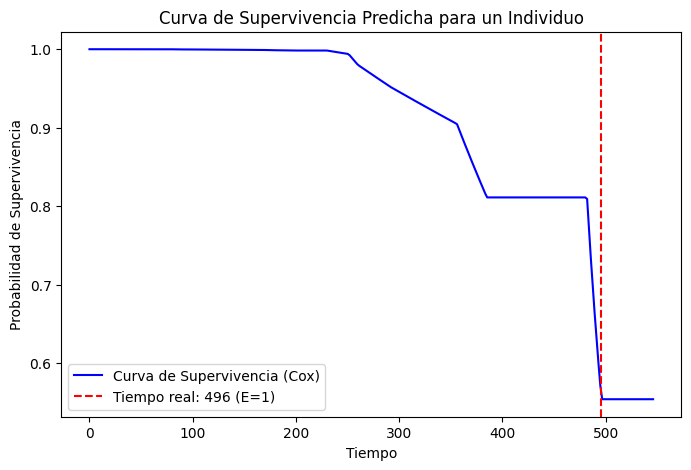


Resumen de la predicción para el individuo:


,real_time,real_event,pred_median,pred_mean
0,496,1,NaN,490.652691


In [22]:
# ----------------------------------------------------------------------------
# 1. Supongamos que 'data' es tu DataFrame con:
#    - 'dias_230': tiempo hasta el evento o censura
#    - 'E': 1 si ocurrió el evento, 0 si está censurado
#    - 'uso_230', 'TPH_acum', 'horometro': variables predictoras
# ----------------------------------------------------------------------------

# Dividir datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Ajustar el modelo de Cox en el conjunto de entrenamiento
cph = CoxPHFitter()
cph.fit(train_data, duration_col="dias_230", event_col="E", formula="uso_230 + TPH_acum + horometro")

# ----------------------------------------------------------------------------
# 2. Seleccionar un individuo del conjunto de prueba para ilustrar
# ----------------------------------------------------------------------------
sample_subject = test_data.sample(1, random_state=25).copy()
# Extraer datos reales de este individuo
real_time = sample_subject["dias_230"].values[0]
real_event = sample_subject["E"].values[0]

print("Individuo seleccionado:")
display(sample_subject)

# ----------------------------------------------------------------------------
# 3. Graficar la curva de supervivencia predicha
# ----------------------------------------------------------------------------
# Definir un rango de tiempos para evaluar la supervivencia
max_time = test_data["dias_230"].max() + 50  # Un poco más allá del tiempo máximo observado
time_grid = np.linspace(0, max_time, 300)

# Curva de supervivencia predicha para el individuo
sf_pred = cph.predict_survival_function(sample_subject, times=time_grid)

# sf_pred es un DataFrame con shape (len(time_grid), n_subjects).
# Si solo tenemos 1 sujeto, sf_pred.iloc[:, 0] es la columna con la supervivencia.

plt.figure(figsize=(8,5))
plt.plot(time_grid, sf_pred.iloc[:, 0], label="Curva de Supervivencia (Cox)", color="blue")

# Marcamos la línea vertical del tiempo real
plt.axvline(real_time, color="red", linestyle="--", label=f"Tiempo real: {real_time} (E={real_event})")

plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curva de Supervivencia Predicha para un Individuo")
plt.legend()
plt.show()

# ----------------------------------------------------------------------------
# 4. Calcular el tiempo mediano y la esperanza de vida aproximada
# ----------------------------------------------------------------------------
sf_values = sf_pred.iloc[:, 0].values  # Prob. de supervivencia en cada t
# 4.1. Tiempo mediano: t donde S(t) cruza 0.5
median_time_candidates = time_grid[sf_values <= 0.5]
if len(median_time_candidates) == 0:
    median_time = np.nan  # No cruza 0.5, prob. de supervivencia > 0.5 en todo el rango
else:
    median_time = median_time_candidates[0]  # Primer punto donde S(t) <= 0.5

# 4.2. Tiempo medio: integral de la curva de supervivencia
# Aproximamos con la regla trapezoidal
mean_time_approx = np.trapz(sf_values, time_grid)

# ----------------------------------------------------------------------------
# 5. Presentar los resultados en una tabla
# ----------------------------------------------------------------------------
result_dict = {
    "real_time": real_time,
    "real_event": real_event,
    "pred_median": median_time,
    "pred_mean": mean_time_approx
}
result_df = pd.DataFrame([result_dict])

print("\nResumen de la predicción para el individuo:")
display(result_df)